In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from scipy.optimize import least_squares, basinhopping, differential_evolution, minimize
import scipy.constants
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from IPython.display import clear_output

In [43]:
f = 5.405e9
c = scipy.constants.c
wavelength = c / f
k = 2 * np.pi * f / c

In [44]:
data = pd.read_csv(r"C:\Users\Mayur\Documents\College\4th sem\Exploratory\Data\Masked_Sentinel1_MODIS_SM_LAI_Freq_Angle_11km.csv")

In [45]:

def clean_data(data):
    # Drop rows with missing data in column: 'LAI'
    data = data.dropna(subset=['LAI'])
    # Drop rows with missing data in columns: 'LAI', 'SoilMoisture'
    data = data.dropna(subset=['LAI', 'SoilMoisture'])
    return data


data_clean = clean_data(data.copy())
data_clean.head()

,system:index,Frequency_GHz,IncidenceAngle,LAI,SoilMoisture,SoilRoughness_placeholder,VH,VV,date,.geo
1,S1A_IW_GRDH_1SDV_20150605T222159_20150605T2222...,5.405,41.307598,0.528001,0.153997,NaN,-17.271151,-9.336902,2015-06-05,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,S1A_IW_GRDH_1SDV_20150617T102014_20150617T1020...,5.405,35.965136,0.666462,0.139027,NaN,-16.080397,-9.373098,2015-06-17,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,S1A_IW_GRDH_1SDV_20150629T102015_20150629T1020...,5.405,35.976403,0.967683,0.168060,NaN,-13.586001,-7.175968,2015-06-29,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,S1A_IW_GRDH_1SDV_20150711T102015_20150711T1020...,5.405,35.969843,1.398233,0.166277,NaN,-16.156059,-9.118385,2015-07-11,"{""type"":""MultiPoint"",""coordinates"":[]}"
5,S1A_IW_GRDH_1SDV_20150723T102016_20150723T1020...,5.405,35.977272,2.128819,0.173480,NaN,-14.791432,-8.001642,2015-07-23,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [46]:
trim_number = 4

mean_vv = data_clean['VV'].mean()
std_vv = data_clean['VV'].std()

data_trimmed = data_clean[(data_clean['VV'] >= mean_vv - trim_number * std_vv) & (data_clean['VV'] <= mean_vv + trim_number * std_vv)]


mean_vh = data_clean['VH'].mean()

std_vh = data_clean['VH'].std()

data_trimmed = data_clean[(data_clean['VH'] >= mean_vh - trim_number * std_vh) & (data_clean['VH'] <= mean_vh + trim_number * std_vv)]

VV_dB = data_trimmed['VV'].values
VH_dB = data_trimmed['VH'].values
SM = data_trimmed['SoilMoisture'].values
LAI = data_trimmed['LAI'].values
theta_deg = data_trimmed['IncidenceAngle']

Trimmed the data at dates which Avoids Rainfall and gets most bare soil

In [47]:
# Convert the 'Date' column to datetime format
data_trimmed['date'] = pd.to_datetime(data_trimmed['date'])

# Define the start and end months for filtering
start_month_day = '05-01'  # April 1
end_month_day = '06-01'    # August 31

# Filter the data for all years between 2015 and 2023
data_segmented = data_trimmed[
    (data_trimmed['date'].dt.strftime('%m-%d') >= start_month_day) &
    (data_trimmed['date'].dt.strftime('%m-%d') <= end_month_day) &
    (data_trimmed['date'].dt.year >= 2015) &
    (data_trimmed['date'].dt.year <= 2023)
]

# Extract the relevant columns after filtering
VV_dB = data_segmented['VV'].values
VH_dB = data_segmented['VH'].values
SM = data_segmented['SoilMoisture'].values
LAI = data_segmented['LAI'].values
theta_deg = data_segmented['IncidenceAngle']

# Ensure all arrays have the same length
min_length = min(len(VH_dB), len(LAI), len(SM))
VH_dB = VH_dB[:min_length]
LAI = LAI[:min_length]
SM = SM[:min_length]

In [48]:
VV_linear = 10**(VV_dB / 10)
VH_linear = 10**(VH_dB / 10)

L Prevot Original 1993 WCM:


In [49]:
def wcm_1993_sigma_0(P1, P2, P3, P4, P5, P6, L, S, theta):
    theta = np.deg2rad(theta)
    t2 = np.exp(-2 * P2 * L / np.cos(theta))
    sigma_veg = P1 * np.power(L, P5) * np.cos(theta)
    sigma_soil = P3 + P4 * S + P6 * L * S  # Added interaction term
    return (sigma_veg + (t2 * sigma_soil))

In [50]:
def wcm_1993_validate_optimizer(optimizer_func):

    params_VV = optimizer_func(VV_dB, LAI, SM, theta_deg)
    predicted_VV = wcm_1993_sigma_0(*params_VV, LAI, SM, theta_deg)

    r2_VV = r2_score(VV_dB, predicted_VV)

    params_VH = optimizer_func(VH_dB, LAI, SM, theta_deg)
    predicted_VH = wcm_1993_sigma_0(*params_VH, LAI, SM, theta_deg)

    r2_VH = r2_score(VH_dB, predicted_VH)

    clear_output()
    print(f"R2 Score For VV:{np.median(r2_VV)}")
    print(f"R2 Score For VH:{np.median(r2_VH)}")
    return (tuple(params_VV), tuple(params_VH))

In [51]:
def optimize_wcm_1993_sigma_0_ls(polarization, L, S, thetas):
    def residuals(params):
        predicted = wcm_1993_sigma_0(*params, L, S, thetas)
        residuals = predicted - polarization
        if not np.all(np.isfinite(residuals)):
            return np.inf
        return residuals
    initial_guess = [0.15, 0.1, 0.1, 0.1, 0.1, 0.1]
    result = least_squares(residuals, initial_guess, method='trf', loss='soft_l1', max_nfev=10000)
    return result.x

In [52]:
def residuals(params, polarization, L, S, thetas):
    predicted = wcm_1993_sigma_0(*params, L, S, thetas)
    return np.sum((predicted - polarization) ** 2)


def optimize_wcm_1993_sigma_0_de_hybrid(polarization, L, S, thetas):
    # Adjusted bounds and parameters for faster optimization
    bounds = [(-10, 10)] * 6
    result_de = differential_evolution(
        residuals,
        bounds,
        args=(polarization, L, S, thetas),  # Pass additional arguments
        maxiter=500,  # Reduced iterations
        popsize=10,   # Smaller population size
        tol=1e-3,     # Increased tolerance
        workers=-1    # Enable parallel computation
    )
    result_local = minimize(
        residuals,
        result_de.x,
        args=(polarization, L, S, thetas),  # Pass additional arguments
        method='L-BFGS-B',
        bounds=bounds
    )
    return result_local.x

In [53]:
wcm_1993_params_vv, wcm_1993_params_vh=wcm_1993_validate_optimizer(optimize_wcm_1993_sigma_0_ls)

R2 Score For VV:0.07217874429096682
R2 Score For VH:0.5412120324243058


In [54]:
#wcm_1993_params_vv, wcm_1993_params_vh = wcm_1993_validate_optimizer(optimize_wcm_1993_sigma_0_VV_de_hybrid)

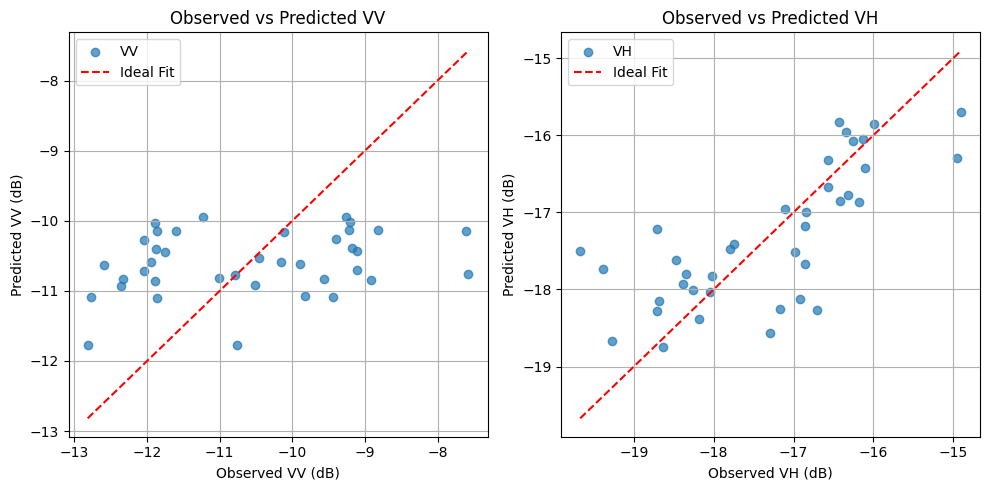

In [55]:


# Generate predictions for VV and VH using the optimized parameters
predicted_VV = wcm_1993_sigma_0(*wcm_1993_params_vv, LAI, SM, theta_deg)
predicted_VH = wcm_1993_sigma_0(*wcm_1993_params_vh, LAI, SM, theta_deg)

# Plot observed vs predicted for VV
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(VV_dB, predicted_VV, alpha=0.7, label="VV")
plt.plot([VV_dB.min(), VV_dB.max()], [VV_dB.min(), VV_dB.max()], 'r--', label="Ideal Fit")
plt.xlabel("Observed VV (dB)")
plt.ylabel("Predicted VV (dB)")
plt.title("Observed vs Predicted VV")
plt.legend()
plt.grid()

# Plot observed vs predicted for VH
plt.subplot(1, 2, 2)
plt.scatter(VH_dB, predicted_VH, alpha=0.7, label="VH")
plt.plot([VH_dB.min(), VH_dB.max()], [VH_dB.min(), VH_dB.max()], 'r--', label="Ideal Fit")
plt.xlabel("Observed VH (dB)")
plt.ylabel("Predicted VH (dB)")
plt.title("Observed vs Predicted VH")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [56]:
# Calculate residuals for VV and VH
residuals_VV = VV_dB - predicted_VV
residuals_VH = VH_dB - predicted_VH

# Define a threshold for large residuals (e.g., 1 standard deviation)
threshold_VV = np.std(residuals_VV)
threshold_VH = np.std(residuals_VH)

# Identify outliers
outliers_VV = data_segmented[np.abs(residuals_VV) > threshold_VV]
outliers_VH = data_segmented[np.abs(residuals_VH) > threshold_VH]

# Randomly select a fraction of outliers to remove
fraction_to_remove = 0.5  # Adjust this fraction as needed (e.g., 0.5 means 50% of outliers)
outliers_VV_to_remove = outliers_VV.sample(frac=fraction_to_remove, random_state=42)
outliers_VH_to_remove = outliers_VH.sample(frac=fraction_to_remove, random_state=42)

# Remove the selected outliers from the dataset
data_segmented_filtered = data_segmented[
    ~data_segmented.index.isin(outliers_VV_to_remove.index) &
    ~data_segmented.index.isin(outliers_VH_to_remove.index)
]

# Print the filtered dataset
print("\nFiltered dataset:")
print(data_segmented_filtered)


Filtered dataset:
                                          system:index  Frequency_GHz  \
45   S1A_IW_GRDH_1SDV_20170501T102007_20170501T1020...          5.405   
46   S1A_IW_GRDH_1SDV_20170501T102032_20170501T1020...          5.405   
47   S1A_IW_GRDH_1SDV_20170513T102007_20170513T1020...          5.405   
49   S1A_IW_GRDH_1SDV_20170525T102008_20170525T1020...          5.405   
50   S1A_IW_GRDH_1SDV_20170525T102033_20170525T1020...          5.405   
103  S1A_IW_GRDH_1SDV_20180508T102013_20180508T1020...          5.405   
104  S1A_IW_GRDH_1SDV_20180508T102038_20180508T1021...          5.405   
105  S1A_IW_GRDH_1SDV_20180601T102014_20180601T1020...          5.405   
106  S1A_IW_GRDH_1SDV_20180601T102039_20180601T1021...          5.405   
159  S1A_IW_GRDH_1SDV_20190503T102019_20190503T1020...          5.405   
162  S1A_IW_GRDH_1SDV_20190515T102045_20190515T1021...          5.405   
163  S1A_IW_GRDH_1SDV_20190527T102020_20190527T1020...          5.405   
164  S1A_IW_GRDH_1SDV_20190527T1

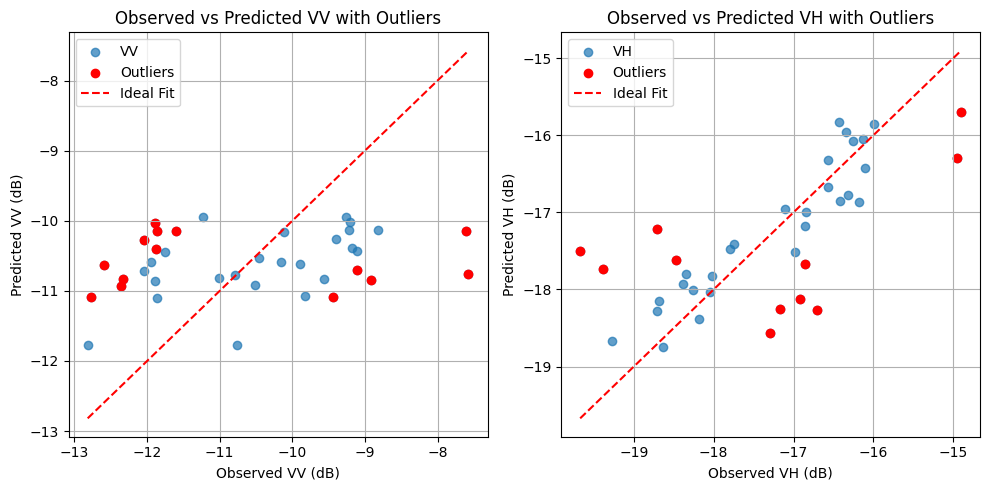

In [57]:
# Highlight outliers on the scatter plot
plt.figure(figsize=(10, 5))

# VV plot
plt.subplot(1, 2, 1)
plt.scatter(VV_dB, predicted_VV, alpha=0.7, label="VV")
# Use the indices of outliers_VV to extract corresponding predicted values
outliers_VV_predicted = predicted_VV[outliers_VV.index]
plt.scatter(outliers_VV['VV'], outliers_VV_predicted, color='red', label="Outliers")
plt.plot([VV_dB.min(), VV_dB.max()], [VV_dB.min(), VV_dB.max()], 'r--', label="Ideal Fit")
plt.xlabel("Observed VV (dB)")
plt.ylabel("Predicted VV (dB)")
plt.title("Observed vs Predicted VV with Outliers")
plt.legend()
plt.grid()

# VH plot
plt.subplot(1, 2, 2)
plt.scatter(VH_dB, predicted_VH, alpha=0.7, label="VH")
# Use the indices of outliers_VH to extract corresponding predicted values
outliers_VH_predicted = predicted_VH[outliers_VH.index]
plt.scatter(outliers_VH['VH'], outliers_VH_predicted, color='red', label="Outliers")
plt.plot([VH_dB.min(), VH_dB.max()], [VH_dB.min(), VH_dB.max()], 'r--', label="Ideal Fit")
plt.xlabel("Observed VH (dB)")
plt.ylabel("Predicted VH (dB)")
plt.title("Observed vs Predicted VH with Outliers")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [58]:
# Recompute variables using the filtered dataset
VV_dB = data_segmented_filtered['VV'].values
VH_dB = data_segmented_filtered['VH'].values
SM = data_segmented_filtered['SoilMoisture'].values
LAI = data_segmented_filtered['LAI'].values
theta_deg = data_segmented_filtered['IncidenceAngle'].values

# Ensure all arrays have the same length
min_length = min(len(VV_dB), len(VH_dB), len(SM), len(LAI))
VV_dB = VV_dB[:min_length]
VH_dB = VH_dB[:min_length]
SM = SM[:min_length]
LAI = LAI[:min_length]
theta_deg = theta_deg[:min_length]

# Retrain the model
wcm_1993_params_vv, wcm_1993_params_vh = wcm_1993_validate_optimizer(optimize_wcm_1993_sigma_0_ls)

# Generate predictions for VV and VH using the retrained model
predicted_VV = wcm_1993_sigma_0(*wcm_1993_params_vv, LAI, SM, theta_deg)
predicted_VH = wcm_1993_sigma_0(*wcm_1993_params_vh, LAI, SM, theta_deg)

# Calculate the new R² scores
r2_VV = r2_score(VV_dB, predicted_VV)
r2_VH = r2_score(VH_dB, predicted_VH)

# Print the new R² scores
print(f"New R² Score for VV: {r2_VV}")
print(f"New R² Score for VH: {r2_VH}")

R2 Score For VV:0.74043788310168
R2 Score For VH:0.7340002347830117
New R² Score for VV: 0.74043788310168
New R² Score for VH: 0.7340002347830117


INVERSION


In [59]:


# WCM forward model


def wcm_1993_sigma_0(P1, P2, P3, P4, P5, P6, L, S, theta):
    theta_rad = np.deg2rad(theta)
    t2 = np.exp(-2 * P2 * L / np.cos(theta_rad))
    sigma_veg = P1 * np.power(L, P5) * np.cos(theta_rad)
    sigma_soil = P3 + P4 * S + P6 * L * S
    return sigma_veg + t2 * sigma_soil

# Separate objective for VV


def objective_vv(params, vv_obs, theta, P):
    L, S = params
    vv_model = wcm_1993_sigma_0(*P, L, S, theta)
    return (vv_model - vv_obs) ** 2

# Separate objective for VH


def objective_vh(params, vh_obs, theta, P):
    L, S = params
    vh_model = wcm_1993_sigma_0(*P, L, S, theta)
    return (vh_model - vh_obs) ** 2

# Inversion function (separate for VV and VH)


def invert_separate_wcm(vv_obs_list, vh_obs_list, theta_list, P_vv, P_vh):
    results_vv = []
    results_vh = []

    for vv_obs, vh_obs, theta in zip(vv_obs_list, vh_obs_list, theta_list):
        x0 = [0.96, 0.16]
        bounds = [(0.01, 6), (0.01, 0.6)]

        # VV inversion
        res_vv = minimize(objective_vv, x0, args=(vv_obs, theta, P_vv), bounds=bounds, method='L-BFGS-B')
        results_vv.append(res_vv.x)  # (LAI_vv, SM_vv)

        # VH inversion
        res_vh = minimize(objective_vh, x0, args=(vh_obs, theta, P_vh), bounds=bounds, method='L-BFGS-B')
        results_vh.append(res_vh.x)  # (LAI_vh, SM_vh)

    return np.array(results_vv), np.array(results_vh)


# Invert
results_vv, results_vh = invert_separate_wcm(VV_dB, VH_dB, theta_deg, wcm_1993_params_vv, wcm_1993_params_vh)
lai_vv, sm_vv = results_vv[:, 0], results_vv[:, 1]
lai_vh, sm_vh = results_vh[:, 0], results_vh[:, 1]

# Print R² scores against ground truth
r2_sm = r2_score(SM, sm_vv)
r2_lai = r2_score(LAI, lai_vh)

print("Inverted from VV:")
print("LAI (VV):", lai_vv)
print("SM  (VV):", sm_vv)

print("\nInverted from VH:")
print("LAI (VH):", lai_vh)
print("SM  (VH):", sm_vh)

print(f"\nLAI R2 (VH): {r2_lai:.4f}")
print(f"SM  R2 (VV): {r2_sm:.4f}")

Inverted from VV:
LAI (VV): [1.41799409 3.20585895 1.26800465 0.93741093 1.32416482 0.93825712
 2.68257991 0.79096182 0.90531009 0.93590225 2.7730346  0.84221623
 1.48176701 0.79032586 1.14355947 1.14937506 0.92543493 0.9693422
 0.9697983  0.9816124  0.90707248 0.77219308 0.96852214 0.96562725
 1.07427414 1.0838625 ]
SM  (VV): [0.15857934 0.1088598  0.1678715  0.20689675 0.16425841 0.20642821
 0.11656235 0.23900617 0.13007573 0.20764671 0.11210927 0.22285089
 0.15508713 0.23927106 0.17670416 0.17637334 0.21169685 0.11671651
 0.11682218 0.11503941 0.1177054  0.14700834 0.11653506 0.15106792
 0.18466987 0.18262   ]

Inverted from VH:
LAI (VH): [0.96937518 1.00057899 0.9660843  0.98696442 0.96419787 0.96114712
 0.99840137 1.01914225 0.96405063 0.96887449 1.01610449 0.96003766
 1.02084775 1.01589896 0.97378366 0.96968884 0.96132177 0.9693758
 0.96003021 0.96301215 0.98828539 0.97812085 0.96084397 0.96370819
 0.97521002 0.97571002]
SM  (VH): [0.29246416 0.40942359 0.25470273 0.01727975 0.23